In [1]:
import random
from datetime import datetime
from tqdm.notebook import tqdm
import statistics
import matplotlib.pyplot as plt
import pandas as pd
import matplotlib.style as style

### Generate Query Data

In [2]:
wordCount = {} # maintains the actual frequency count
with open("train.data") as input_file:
    input_line = input_file.readline()
    while input_line:
        groupNo, wordIDx, count = map(int, input_line.split())
        if wordIDx in wordCount:
            wordCount[wordIDx] += 1
        else:
            wordCount[wordIDx] = 1
        input_line = input_file.readline()
wordCountList = []
for key, value in wordCount.items():
    wordCountList.append([key, value])
wordCountList.sort(key = lambda x: x[1], reverse = True)
# The number of actual unique word count
print("Number of Unique words: ", len(wordCountList))
# Sample 100 items from the 1000 most frequent words
queryList = random.sample(wordCountList[:1000], 100)
with open("query.data", "w") as query_file:
    for a,b in queryList:
        query_file.write(str(a) + " " + str(b) + "\n")
print("Query Data successfully written to file query.data")

Number of Unique words:  53975
Query Data successfully written to file query.data


### Misra-Gries Sketch

In [3]:
class MisraGries:
    def __init__(self, k):
        self.k = k
        self.counters = {}
        
    def process(self, element, count):
        if element in self.counters:
            self.counters[element] += count
        elif len(self.counters) < self.k - 1:
            self.counters[element] = count
        else:
            frequencyToDecrease = count
            for key, val in self.counters.items():
                frequencyToDecrease = min(frequencyToDecrease, val)
            for key in self.counters:
                self.counters[key] -= frequencyToDecrease
            # Remove all keys whose frequency is <= 0
            self.counters = {key:val for key, val in self.counters.items() if val > 0}
            if count > frequencyToDecrease:
                self.counters[element] = count - frequencyToDecrease
            # If the new inserted element has count <= frequencyToDecrease, it will be removed
            self.counters = {key:val for key, val in self.counters.items() if val > 0}
            
    def query(self, element):
        if element in self.counters:
            return self.counters[element]
        return 0

### Count-min Sketch

In [4]:
class CountMinSketch:
    def __init__(self, numRows, numCols):
        self.p = 104207
        self.hash_functions = []   # stores the a,b for the hash functions
        self.numRows, self.numCols = numRows, numCols
        for _ in range(numRows):
            random.seed(datetime.now())
            a = random.randint(1, self.p - 1)
            b = random.randint(1, self.p - 1)
            self.hash_functions.append((a,b))
        self.countArray = [[0] * numCols for i in range(numRows)]

    def hash_value(self, rowID, element):
        a, b = self.hash_functions[rowID]
        return ((a * element + b) % self.p) % self.numCols
   
    def process(self, element, count):
        for rowID in range(self.numRows):
            colID = self.hash_value(rowID, element)
            self.countArray[rowID][colID] += count
                
    def query(self, element):
        tempCountArray = []
        for rowID in range(self.numRows):
            colID = self.hash_value(rowID, element)
            tempCountArray.append(self.countArray[rowID][colID])
        return min(tempCountArray)

### count Sketch

In [5]:
class CountSketch:
    def __init__(self, numRows, numCols):
        self.p = 104207
        self.hash_functions = []
        self.sign_hash_functions = []
        self.numRows, self.numCols = numRows, numCols
        # Generate the hash functions and sign hash functions
        for _ in range(numRows):
            random.seed(datetime.now())
            a = random.randint(1, self.p - 1)
            b = random.randint(1, self.p - 1)
            self.hash_functions.append((a,b))
            random.seed(datetime.now())
            a = random.randint(1, self.p - 1)
            b = random.randint(1, self.p - 1)
            self.sign_hash_functions.append((a,b))
        self.countArray = [[0] * numCols for i in range(numRows)]
    # returns the column number
    def hash_value(self, rowID, element):
        a, b = self.hash_functions[rowID]
        return ((a * element + b) % self.p) % self.numCols
   # returns the sign, gi
    def sign_hash_value(self, rowID, element):
        a, b = self.sign_hash_functions[rowID]
        hash_val = ((a * element + b) % self.p) % 2
        if hash_val == 0:
            return -1
        return 1
    
    def process(self, element, count):
        for rowID in range(self.numRows):
            colID = self.hash_value(rowID, element)
            sign = self.sign_hash_value(rowID, element)
            self.countArray[rowID][colID] += sign * count
                
    def query(self, element):
        tempCountArray = []
        for rowID in range(self.numRows):
            colID = self.hash_value(rowID, element)
            sign = self.sign_hash_value(rowID, element)
            tempCountArray.append(sign * self.countArray[rowID][colID])
        return int(statistics.median(tempCountArray))

### Average Relative Error for different k

In [6]:
w = 5
k_list = (100, 200, 500, 1000, 2000)
mGriesRelativeErrorList, countMinRelativeErrorList, countSketchRelativeErrorList = [], [], []
for k in tqdm(k_list, leave = False):
    d = k // w
    mGries = MisraGries(k)
    countMin = CountMinSketch(w, d)
    countSketch = CountSketch(w, d)
    # Run the three sketches on the train data
    with open("train.data") as input_file:
        input_line = input_file.readline()
        while input_line:
            groupNo, wordIDx, count = map(int, input_line.split())
            mGries.process(wordIDx, count)
            countMin.process(wordIDx, count)
            countSketch.process(wordIDx, count)
            input_line = input_file.readline()
    # Query the three structures and maintain the relative errors
    mGriesRelativeError, countMinRelativeError, countSketchRelativeError = 0, 0, 0
    with open("query.data") as query_file:
        input_line = query_file.readline()
        while input_line:
            wordIDx, actualCount = map(int, input_line.split())
            mGriesRelativeError += abs(mGries.query(wordIDx) - actualCount) / actualCount
            countMinRelativeError += abs(countMin.query(wordIDx) - actualCount) / actualCount
            countSketchRelativeError += abs(countSketch.query(wordIDx) - actualCount) / actualCount
            input_line = query_file.readline()
    mGriesRelativeError /= 100
    countMinRelativeError /= 100
    countSketchRelativeError /= 100
    mGriesRelativeErrorList.append(mGriesRelativeError)
    countMinRelativeErrorList.append(countMinRelativeError)
    countSketchRelativeErrorList.append(countSketchRelativeError)

  0%|          | 0/5 [00:00<?, ?it/s]

In [7]:
df = pd.DataFrame({'k': k_list, 
                   'misra-gries' : mGriesRelativeErrorList,
                  'count-min' : countMinRelativeErrorList,
                  'count sketch' : countSketchRelativeErrorList})
df = df.set_index('k')
display(df)

,misra-gries,count-min,count sketch
k,,,
100,0.999994,239.442950,35.067111
200,0.999888,106.094061,21.996292
500,0.957877,34.363770,7.377537
1000,0.910429,15.946000,3.802347
2000,0.775348,6.900819,2.006081


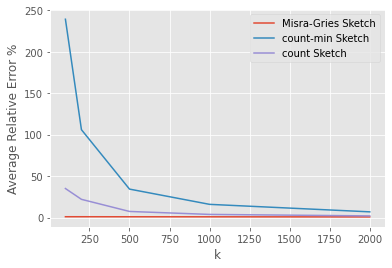

In [13]:
style.use('ggplot')
plt.plot(k_list, mGriesRelativeErrorList, label = "Misra-Gries Sketch")
plt.plot(k_list, countMinRelativeErrorList, label = "count-min Sketch")
plt.plot(k_list, countSketchRelativeErrorList, label = "count Sketch")
plt.legend()
plt.xlabel("k") 
plt.ylabel("Average Relative Error %")
plt.show()

### min w for average error < 1% (using Binary Search)

#### Misra-Gries Sketch

In [9]:
# Binary Search
start_k = 1
end_k = 10000
answer_k = end_k
mid_k = (start_k + end_k) // 2
while mid_k <= end_k and mid_k >= start_k:
    mGries = MisraGries(mid_k)
    with open("train.data") as input_file:
        input_line = input_file.readline()
        while input_line:
            groupNo, wordIDx, count = map(int, input_line.split())
            mGries.process(wordIDx, count)
            input_line = input_file.readline()
    mGriesRelativeError = 0
    with open("query.data") as query_file:
        input_line = query_file.readline()
        while input_line:
            wordIDx, actualCount = map(int, input_line.split())
            mGriesRelativeError += abs(mGries.query(wordIDx) - actualCount) / actualCount
            input_line = query_file.readline()
    mGriesRelativeError /= 100  
    if mGriesRelativeError < 1:
        answer_k = mid_k
        end_k = mid_k - 1
    else:
        start_k = mid_k + 1  
    print(mid_k, start_k, end_k, mGriesRelativeError)
    mid_k = (start_k + end_k) // 2
print("Min k for 1% average error is:", answer_k)

5000 1 4999 0.3515167503364409
2500 1 2499 0.6781775537717284
1250 1 1249 0.8857543269295028
625 1 624 0.9443713301449899
312 1 311 0.9805867221190764
156 1 155 0.9999824421646701
78 1 77 0.9999971687429218
39 40 77 1.0
58 59 77 1.0
68 69 77 1.0
73 69 72 0.9999971687429218
70 71 72 1.0
71 72 72 1.0
72 72 71 0.9999971687429218
Min k for 1% average error is: 72


#### count-min Sketch

In [10]:
#Binary Search
start_w = 1
end_w = 10000
answer_w = end_w
mid_w = (start_w + end_w) // 2
while mid_w <= end_w and mid_w >= start_w:
    countMin = CountMinSketch(5, mid_w)
    with open("train.data") as input_file:
        input_line = input_file.readline()
        while input_line:
            groupNo, wordIDx, count = map(int, input_line.split())
            countMin.process(wordIDx, count)
            input_line = input_file.readline()
    countMinRelativeError = 0
    with open("query.data") as query_file:
        input_line = query_file.readline()
        while input_line:
            wordIDx, actualCount = map(int, input_line.split())
            countMinRelativeError += abs(countMin.query(wordIDx) - actualCount) / actualCount
            input_line = query_file.readline()
    countMinRelativeError /= 100  
    if countMinRelativeError < 1:
        answer_w = mid_w
        end_w = mid_w - 1
    else:
        start_w = mid_w + 1  
    print(mid_w, start_w, end_w, countMinRelativeError)
    mid_w = (start_w + end_w) // 2
print("Min w for average error < 1% :", answer_w)

5000 1 4999 0.631224661634355
2500 1 2499 0.9900919365180273
1250 1251 2499 1.7734116846201136
1875 1876 2499 1.2308164214938027
2187 2188 2499 1.200392406432636
2343 2344 2499 1.013366995116046
2421 2422 2499 1.0163455818866278
2460 2461 2499 1.0251196438767132
2480 2481 2499 1.0004887863678598
2490 2481 2489 0.9862257189422817
2485 2481 2484 0.9851902890859086
2482 2481 2481 0.9494146406024413
2481 2481 2480 0.9057107879331876
Min w for average error < 1% : 2481


#### count Sketch

In [11]:
#Binary Search
start_w = 1
end_w = 10000
answer_w2 = end_w
mid_w = (start_w + end_w) // 2
while mid_w <= end_w and mid_w >= start_w:
    countSketch = CountSketch(5, mid_w)
    with open("train.data") as input_file:
        input_line = input_file.readline()
        while input_line:
            groupNo, wordIDx, count = map(int, input_line.split())
            countSketch.process(wordIDx, count)
            input_line = input_file.readline()
    countSketchRelativeError = 0
    with open("query.data") as query_file:
        input_line = query_file.readline()
        while input_line:
            wordIDx, actualCount = map(int, input_line.split())
            countSketchRelativeError += abs(countSketch.query(wordIDx) - actualCount) / actualCount
            input_line = query_file.readline()
    countSketchRelativeError /= 100  
    if countSketchRelativeError < 1:
        answer_w2 = mid_w
        end_w = mid_w - 1
    else:
        start_w = mid_w + 1  
    print(mid_w, start_w, end_w, countSketchRelativeError)
    mid_w = (start_w + end_w) // 2
print("Min w for average error < 1% :", answer_w2)

5000 1 4999 0.5712966246325957
2500 1 2499 0.6145178299625624
1250 1 1249 0.7930102315796015
625 626 1249 1.1204720857619377
937 626 936 0.936701937361133
781 782 936 1.0888204373643031
859 860 936 1.120448539306236
898 899 936 1.588386016866834
917 899 916 0.8815909873336374
907 899 906 0.9877757755443238
902 903 906 1.5585286143128962
904 903 903 0.8432443145623167
903 904 903 1.0147207058212553
Min w for average error < 1% : 904
